# Implementing a Seq2Seq model using a ransformer architecture

### About this notebook

This notebook was created as a deliverable for the group project under 50.039 Deep Learning course at the Singapore University of Technology and Design.

**Author:** Group 09 - Cohort 01


## Define device for Torch - preferred CUDA for accelerated computation

In [1]:
# Matplotlib
import torch

# Define device for torch
use_cuda = True
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA is available: True


## Load model hyperparameters from the configuration file

In [2]:
import sys
import os
import importlib

sys.path.append(os.path.abspath(".."))  # or path to your root project

import config.config_Transformer as config

# Reload current version of the config file
importlib.reload(config)

INPUT_SIZE = config.INPUT_SIZE
OUTPUT_SIZE = config.OUTPUT_SIZE
N_INPUTS = config.N_INPUTS
N_OUTPUTS = config.N_OUTPUTS
HIDDEN_SIZE = config.HIDDEN_SIZE
NHEAD = config.NHEAD
NUMBER_LAYERS = config.NUMBER_LAYERS
DROPOUT_RATE = config.DROPOUT_RATE
LEARNING_RATE = config.LEARNING_RATE
NUM_EPOCHS = config.NUM_EPOCHS

print("Data dimensions:")
print("INPUT_SIZE:", INPUT_SIZE)
print("OUTPUT_SIZE:", OUTPUT_SIZE)
print("N_INPUTS:", N_INPUTS)
print("N_OUTPUTS:", N_OUTPUTS)
print("Model architecture parameters:")
print("HIDDEN_SIZE:", HIDDEN_SIZE)
print("NHEAD:", NHEAD)
print("NUMBER_LAYERS:", NUMBER_LAYERS)
print("DROPOUT_RATE:", DROPOUT_RATE)
print("Training hyperparameters:")
print("LEARNING_RATE:", LEARNING_RATE)
print("NUM_EPOCHS:", NUM_EPOCHS)

Data dimensions:
INPUT_SIZE: 4
OUTPUT_SIZE: 4
N_INPUTS: 30
N_OUTPUTS: 7
Model architecture parameters:
HIDDEN_SIZE: 64
NHEAD: 4
NUMBER_LAYERS: 2
DROPOUT_RATE: 0.2
Training hyperparameters:
LEARNING_RATE: 0.001
NUM_EPOCHS: 300


## Import train and test dataset

### Define load dataset function

In [3]:
import pandas as pd

def load_dataset(train_path, test_path):
    # Load and drop date column
    train_df = pd.read_csv(train_path, parse_dates=['date']).drop(columns=['date'])
    test_df = pd.read_csv(test_path, parse_dates=['date']).drop(columns=['date'])

    # Normalize using training statistics
    stats = train_df.describe().transpose()

    def normalize(df):
        return (df - stats["mean"]) / stats["std"]

    train_norm = normalize(train_df)
    test_norm = normalize(test_df)

    return train_norm, test_norm, stats

### Load train and test dataset

In [4]:
# Load dataset from file
train_file_path = '../dataset/train/DailyDelhiClimateTrain.csv'
test_file_path = '../dataset/test/DailyDelhiClimateTest.csv'
train_data, test_data, stats = load_dataset(train_file_path, test_file_path)

In [5]:
train_data[:5]

,meantemp,humidity,wind_speed,meanpressure
0,-2.108778,1.414955,-1.491189,0.025313
1,-2.462611,1.862191,-0.837909,0.037149
2,-2.494366,1.564034,-0.475464,0.041958
3,-2.290231,0.629806,-1.220816,0.033635
4,-2.653137,1.554095,-0.680070,0.029936


In [6]:
# number of samples in train dataset
print("Number of train samples:", len(train_data))

Number of train samples: 1462


## Define Pytorch Dataset and Dataloader objects

In [7]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

### Dataset object

In [8]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, n_inputs, n_outputs):
        self.dataframe = dataframe
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.inputs = []
        self.outputs = []
        self.define_samples()

    def define_samples(self):
        data_array = self.dataframe.values
        for i in range(len(data_array) - self.n_inputs - self.n_outputs):
            input_seq = data_array[i:i+self.n_inputs, :]         # Sequence length of 30, incl all features
            output_seq = data_array[i+self.n_inputs:i+self.n_inputs+self.n_outputs, :]  # Sequence length of 7, incl all features
            self.inputs.append(input_seq)
            self.outputs.append(output_seq)
        print(output_seq)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        x = torch.tensor(self.inputs[idx], dtype=torch.float32)  # Shape: (n_inputs, 4)
        y = torch.tensor(self.outputs[idx], dtype=torch.float32) # Shape: (n_outputs,)
        return x, y

In [9]:
n_inputs = N_INPUTS
n_outputs = N_OUTPUTS

train_dataset = CustomDataset(train_data, n_inputs, n_outputs)
test_dataset = CustomDataset(test_data, n_inputs, n_outputs)

[[-1.56442024  1.99934369  0.50043629  0.01800712]
 [-1.13671023  0.8399364   0.43449685  0.0324462 ]
 [-1.17656502  0.4042003   0.33602037  0.0338201 ]
 [-1.12656691  0.43362716 -0.71342974  0.02474964]
 [-1.39592842  1.61514627 -0.17586118  0.03218199]
 [-1.55145933  1.72305094 -0.11740219  0.03773041]
 [-1.42116808  1.56403353  0.11460694  0.02771684]]
[[ 0.96079698 -1.33140847 -0.31470129 -0.03695301]
 [ 1.15737077 -1.99398101  0.22117281 -0.0443509 ]
 [ 1.089326   -2.18529884  0.48728301 -0.05675777]
 [ 1.22541555 -1.98404243 -0.27177047 -0.0692417 ]
 [ 1.19139316 -1.27591802  0.03513924 -0.06230618]
 [ 1.00767227 -1.18497994  0.45768815 -0.05273517]
 [ 1.00427003 -1.98404243  0.69280291 -0.04982225]]


In [10]:
train_dataset[0]

(tensor([[-2.1088e+00,  1.4150e+00, -1.4912e+00,  2.5313e-02],
         [-2.4626e+00,  1.8622e+00, -8.3791e-01,  3.7149e-02],
         [-2.4944e+00,  1.5640e+00, -4.7546e-01,  4.1958e-02],
         [-2.2902e+00,  6.2981e-01, -1.2208e+00,  3.3635e-02],
         [-2.6531e+00,  1.5541e+00, -6.8007e-01,  2.9936e-02],
         [-2.5170e+00,  1.3136e+00, -1.1667e+00,  3.8259e-02],
         [-2.5170e+00,  1.0631e+00, -1.1009e-01,  4.9356e-02],
         [-2.2643e+00,  1.7547e-01,  7.4677e-02,  4.2222e-02],
         [-1.5644e+00, -5.6779e-01,  1.2491e+00,  3.2710e-02],
         [-1.9727e+00,  7.3245e-02,  1.3105e-01,  2.5313e-02],
         [-1.3311e+00, -5.6566e-01,  8.2629e-01,  2.7955e-02],
         [-1.5644e+00,  7.8882e-01,  1.4088e+00,  2.4784e-02],
         [-1.3149e+00,  8.5839e-01, -4.7546e-01,  1.2366e-02],
         [-1.7232e+00,  1.6336e+00, -1.3560e+00,  2.2538e-02],
         [-1.4672e+00,  6.6104e-01, -1.3753e+00,  2.6369e-02],
         [-1.5871e+00,  1.5442e+00, -1.4912e+00,  3.086

### Dataloader Object

In [11]:
# Define batch size
batch_size = 128

# Random number generator (for reproducibility)
generator = torch.Generator()  # Defaults to CPU, which DataLoader expects

# Create DataLoader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    generator=generator
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,  # Important: don't shuffle test data
    generator=generator
)

In [12]:
# Visualize a sample
sample = next(iter(train_dataloader))
input_sample, output_sample = sample
print("Input shape:", input_sample.shape)
print("Output shape:", output_sample.shape)
print("Number of batches:", len(train_dataloader))

Input shape: torch.Size([128, 30, 4])
Output shape: torch.Size([128, 7, 4])
Number of batches: 12


In [13]:
len(train_dataloader)

12

## Define Model Architecture

#### Time Series Embedding

The `TimeSeriesEmbedding` layer maps each raw 4D input feature vector (for example, temperature, wind speed, and pressure) to a higher_dimensional space (d_model). This step is crucial because the Transformer requires input embeddings of uniform size for both the encoder and decoder. By project the features into a richer space, the model can more easily capture and process complex patterns in the time-series data.

In [14]:
import torch.nn as nn
import math

In [ ]:
class TimeSeriesEmbedding(nn.Module):
    """
    Maps each 4D input vector to a higher-dimensional embedding (d_model)
    """
    def __init__(self, input_dim, d_model):
        super().__init__()
        self.linear = nn.Linear(input_dim, d_model)

    def forward(self, x):
        # Shape of input x: (batch_size, seq_len, input_dim)
        return self.linear(x)  # (batch_size, seq_len, d_model)

#### Positional Encoding

Since the Transformer architecture does not have any recurrence or convolution, it lacks an intrinsic sense of order. The `PositionalEncoding` layer injects the position (or time step) information into the embeddings. It adds sinosoidal patterns, using sine and consine functions with varying frequencies, to the input embeddings. This allows the model to capture the relative and absolute order of the time steps.

In [ ]:
class PositionalEncoding(nn.Module):
    """
    Adds sinusoidal positional encodings to the embedded vectors
    to incorporate sequence order into the Transformer
    """
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float()
                             * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1)  # shape: (max_len, 1, d_model)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        x: (seq_len, batch_size, d_model)
        We add the positional encoding up to x.size(0) (the seq_len)
        """
        seq_len = x.size(0)
        return x + self.pe[:seq_len, :]

#### Transformer Masking

In an autoregressive decoding, it is essential to prevent the model from attending to future time steps during training (teacher forcing or autoregressive generation). The function `generate_square_subsequent_mask` produces an upper-triangular mask. In this mask, positions corresponding to future time steps are filled with negative infinity. This tells the attention mechanism not to consider these positions when computing the decoder outputs.

In [ ]:
def generate_square_subsequent_mask(sz: int) -> torch.Tensor:
    """
    Generates an upper-triangular matrix of -inf, with zeros on diagonal
    Used to mask future positions in the decoder for auto‐regressive or
    teacher-forcing style training
    """
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

#### Seq2Seq Transformer Model

The `Seq2SeqTransformer` class implements a sequence-to-sequence model for multivariate time-series forecasting using the Transformer architecture. The model begins by embedding both source and target sequences into a common high-dimensional space, enabling a richer representation of the raw 4-dimensional input features. Positional information is then added to preserve the temporal order of the sequence, which the Transformer cannot inherently model. The encoder is composed of multiple `nn.TransformerEncoderLayer` modules, stacked using `nn.TransformerEncoder`. Each layer applies multi-head self-attention across all input time steps, allowing the model to learn dependencies between past observations, followed by a feedforward sublayer that refines each timestep's representation. The decoder follows a similar layered structure using `nn.TransformerDecoder`, where each `nn.TransformerDecoderLayer` first performs masked self-attention on the target sequence—restricting access to future time steps—and then applies cross-attention over the encoder’s output to integrate contextual signals from the input sequence. A square subsequent mask is generated during training to enforce this autoregressive behavior. Finally, the decoder outputs are passed through a linear layer to project them back to the original feature dimension, producing multi-step forecasts.

In [ ]:
class Seq2SeqTransformer(nn.Module):
    """
    A standard Transformer-based model for time-series forecasting:
    - Embeds the (batch, seq_len, 4) input to (seq_len, batch, d_model)
    - Feeds it into the Encoder
    - Uses the Decoder with an optional target to produce predictions
    - Outputs a final linear projection to get back to 4 features
    """
    def __init__(self,
                 input_dim=INPUT_SIZE,
                 d_model=HIDDEN_SIZE,
                 nhead=NHEAD,
                 num_encoder_layers=NUMBER_LAYERS,
                 num_decoder_layers=NUMBER_LAYERS,
                 dropout=DROPOUT_RATE,
                 output_dim=OUTPUT_SIZE):
        super(Seq2SeqTransformer, self).__init__()

        # Embedding layers for source and target
        self.input_emb = TimeSeriesEmbedding(input_dim, d_model)
        self.target_emb = TimeSeriesEmbedding(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        # Transformer blocks
        # Encoder block
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model,
                                                   nhead=nhead,
                                                   dropout=dropout,
                                                   batch_first=False)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)

        # Decoder block
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model,
                                                   nhead=nhead,
                                                   dropout=dropout,
                                                   batch_first=False)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        # Final linear projection back to (4) features
        self.output_linear = nn.Linear(d_model, output_dim)

        self.d_model = d_model

    def forward(self, src, tgt):
        """
        src: (seq_len_in, batch_size, input_dim=4)
        tgt: (seq_len_out, batch_size, input_dim=4)
        Returns: (seq_len_out, batch_size, output_dim=4)
        """
        # Encode: Embed source and add positional encodings
        src_emb = self.input_emb(src)   # (seq_len_in, batch, d_model)
        src_emb = self.pos_encoder(src_emb)
        # Pass through Transformer Encoder
        memory = self.encoder(src_emb)  # (seq_len_in, batch, d_model)

        # Decode: Embed target and add positional encodings
        tgt_emb = self.target_emb(tgt)  # (seq_len_out, batch, d_model)
        tgt_emb = self.pos_encoder(tgt_emb)

        # Generate causal mask for decoder to prevent attending to future time steps during training
        seq_len_out = tgt.size(0)
        tgt_mask = generate_square_subsequent_mask(seq_len_out).to(tgt.device)

        # Decode using encoder output as memory
        decoder_output = self.decoder(tgt=tgt_emb,
                                      memory=memory,
                                      tgt_mask=tgt_mask)

        # Project decoder output back to original feature dimensions
        out = self.output_linear(decoder_output)  # shape: (seq_len_out, batch, output_dim=4)
        return out

## Model training

#### Define function for training

In [ ]:
loss_storage = []

def train_transformer_model(dataloader, model, num_epochs, learning_rate, device):
    # Set model to training mode
    model.train()

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        total_loss = 0.0
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            # inputs shape: (batch_size, seq_len_in, 4)
            # targets shape: (batch_size, seq_len_out, 4)
            # Move to device
            inputs = inputs.to(device)
            targets = targets.to(device)

            # Permute to (seq_len, batch_size, 4)
            inputs = inputs.permute(1, 0, 2) # (T_in, B, 4)
            targets = targets.permute(1, 0, 2)  # (T_out, B, 4)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass with teacher forcing
            predictions = model(inputs, targets)  # (seq_len_out, batch_size, 4)

            # Compute loss
            loss = criterion(predictions, targets)
            total_loss += loss.item()

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

        avg_loss = total_loss / len(dataloader)
        loss_storage.append(avg_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}")

    return loss_storage


#### Instantiate the Transformer model

In [18]:
# Instantiate the Transformer model
seq2seq_transformer = Seq2SeqTransformer(
    input_dim=INPUT_SIZE,
    d_model=HIDDEN_SIZE,
    nhead=NHEAD,
    num_encoder_layers=NUMBER_LAYERS,
    num_decoder_layers=NUMBER_LAYERS,
    dropout=DROPOUT_RATE,
    output_dim=OUTPUT_SIZE
).to(device)

print("Transformer model instantiated:")
print(seq2seq_transformer)

/opt/conda/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Transformer model instantiated:
Seq2SeqTransformer(
  (input_emb): TimeSeriesEmbedding(
    (linear): Linear(in_features=4, out_features=64, bias=True)
  )
  (target_emb): TimeSeriesEmbedding(
    (linear): Linear(in_features=4, out_features=64, bias=True)
  )
  (pos_encoder): PositionalEncoding()
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
    )
  )


### Train model

In [ ]:
# Train the Transformer model
loss_storage = train_transformer_model(
    dataloader=train_dataloader,
    model=seq2seq_transformer,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    device=device
)

Epoch [1/300] - Loss: 0.9543
Epoch [2/300] - Loss: 0.4300
Epoch [3/300] - Loss: 0.3251
Epoch [4/300] - Loss: 0.2702
Epoch [5/300] - Loss: 0.2441
Epoch [6/300] - Loss: 0.2300
Epoch [7/300] - Loss: 0.2225
Epoch [8/300] - Loss: 0.2130
Epoch [9/300] - Loss: 0.2073
Epoch [10/300] - Loss: 0.2037
Epoch [11/300] - Loss: 0.1990
Epoch [12/300] - Loss: 0.1951
Epoch [13/300] - Loss: 0.1898
Epoch [14/300] - Loss: 0.1855
Epoch [15/300] - Loss: 0.1796
Epoch [16/300] - Loss: 0.1766
Epoch [17/300] - Loss: 0.1727
Epoch [18/300] - Loss: 0.1684
Epoch [19/300] - Loss: 0.1644
Epoch [20/300] - Loss: 0.1611
Epoch [21/300] - Loss: 0.1586
Epoch [22/300] - Loss: 0.1551
Epoch [23/300] - Loss: 0.1498
Epoch [24/300] - Loss: 0.1471
Epoch [25/300] - Loss: 0.1467
Epoch [26/300] - Loss: 0.1404
Epoch [27/300] - Loss: 0.1387
Epoch [28/300] - Loss: 0.1340
Epoch [29/300] - Loss: 0.1306
Epoch [30/300] - Loss: 0.1284
Epoch [31/300] - Loss: 0.2355
Epoch [32/300] - Loss: 0.1292
Epoch [33/300] - Loss: 0.1209
Epoch [34/300] - Lo

### Save the model parameter

In [20]:
# Save model before eval
model_name="seq2seq_Transformer"

# Path to save model
model_path = os.path.join("../models_weights_storage", f'{model_name}.pth')

# Save the model's state dict
torch.save(seq2seq_transformer.state_dict(), model_path)
print(f"Model saved to: {model_path}")

Model saved to: ../models_weights_storage/seq2seq_Transformer.pth


In [21]:
print("Training loss history:", loss_storage)

Training loss history: [0.9543260037899017, 0.43003468836347264, 0.32513048375646275, 0.270157964900136, 0.24406386663516363, 0.23003835106889406, 0.22248675705244145, 0.21299673399577537, 0.20728247053921223, 0.20370231258372465, 0.19897283799946308, 0.1951391901820898, 0.18980674725025892, 0.18549177454163632, 0.17959152177597085, 0.17660526651889086, 0.17274848589052758, 0.16835490707308054, 0.16436054200554887, 0.16109380754642189, 0.15864898194558918, 0.15510590902219215, 0.14980396108391383, 0.14707252204728624, 0.1466956912384679, 0.14037157393371066, 0.13867898471653461, 0.13399880387199423, 0.13062306966943046, 0.12844292206379274, 0.2354971747069309, 0.12921503535471857, 0.12088222289457917, 0.11730476949984829, 0.11164532322436571, 0.19719441848186156, 0.10482408238264422, 0.1021288411381344, 0.09864151175133884, 0.09495856900078554, 0.16761156769158939, 0.0930158228147775, 0.08708887407556176, 0.08254603083090235, 0.1436429830888907, 0.08422060442777972, 0.08487996459007263

## Plot loss curve during model training

### Define a function to plot the loss curve

In [22]:
import matplotlib.pyplot as plt

def plot_loss_curve(loss_storage, tick_interval=10,save_path=None):
    plt.figure(figsize=(12, 6))

    epochs = list(range(1, len(loss_storage) + 1))

    # Plot the loss
    plt.plot(
        epochs,
        loss_storage,
        color='royalblue',
        marker='o',
        linestyle='-',
        linewidth=2,
        markersize=4,
        label='Training Loss'
    )

    # Title & labels
    plt.title("Training Loss Curve", fontsize=18, fontweight='bold')
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Loss", fontsize=14)

    # Set x-ticks with wider spacing
    plt.xticks(
        ticks=range(0, len(loss_storage) + 1, tick_interval),
        fontsize=12
    )
    plt.yticks(fontsize=12)

    # Grid, legend and layout
    plt.grid(True, linestyle='--', linewidth=0.5)
    plt.legend(fontsize=12)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Loss curve saved to: {save_path}")

    plt.show()


### Plot the loss curve and save the image

Loss curve saved to: ../images_model_training_and_eval/seq2seq_Transformer_loss_training_curve.png


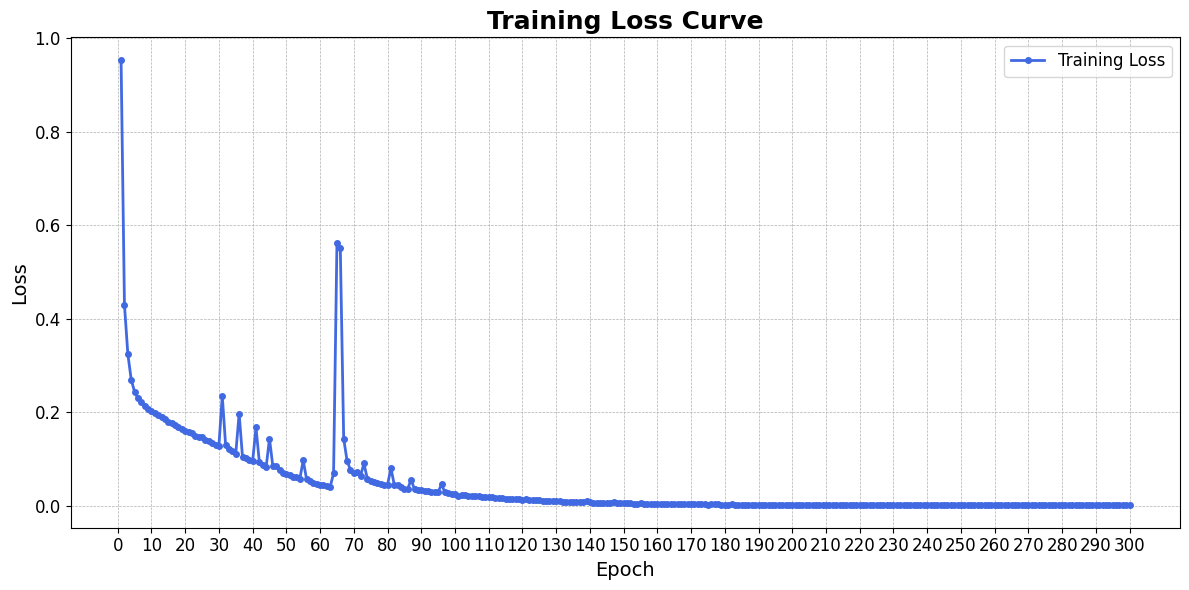

In [23]:
save_path="../images_model_training_and_eval/seq2seq_Transformer_loss_training_curve.png"

plot_loss_curve(loss_storage,save_path=save_path)

## Model Evaluation

### Define evaluation model function

In [ ]:
def evaluate_transformer_model(model, dataloader, device, seed_value):
    model.eval()
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    np.random.seed(seed_value)

    with torch.no_grad():
        inputs, outputs = next(iter(dataloader))
        inputs, outputs = inputs.to(device), outputs.to(device)

        inputs_seq = inputs.permute(1, 0, 2)
        outputs_seq = outputs.permute(1, 0, 2)

        pred = model(inputs_seq, outputs_seq)

        pred_vals = pred.cpu().numpy()
        true_vals = outputs.permute(1, 0, 2).cpu().numpy()
        mae = np.mean(np.abs(true_vals - pred_vals))

        print("Ground truth:\n", true_vals[:, 0, :])
        print("Prediction:\n", pred_vals[:, 0, :])
        print("MAE:", mae)

        feature_mae = np.mean(np.abs(true_vals - pred_vals), axis=(0, 1))
        print("Feature-wise MAE:", feature_mae)
        return mae



In [25]:
seed_value = 187

mae_value = evaluate_transformer_model(
    model=seq2seq_transformer,
    dataloader=test_dataloader,
    device=device,
    seed_value=seed_value
)

Ground truth:
 [[-1.2752299   0.9080867  -0.47729036  0.02438779]
 [-1.3943083   1.0646194  -0.37316027  0.03548462]
 [-1.1437798   0.3442977  -0.82754606  0.04330284]
 [-1.3417282   1.0381919  -1.0846328   0.03674562]
 [-0.9247994   1.0034971   0.6615639   0.01828454]
 [-0.93411076  1.0053803   0.28450337  0.01723326]
 [-1.1712726   0.53042036  0.49154565  0.027162  ]]
Prediction:
 [[-1.2738374   0.90636307 -0.47574273  0.02986424]
 [-1.394206    1.070875   -0.3718609   0.03191098]
 [-1.1443764   0.3489382  -0.824768    0.04532637]
 [-1.3446432   1.045648   -1.0811068   0.02784457]
 [-0.93771183  1.0102587   0.6683628   0.00291698]
 [-0.9431884   1.0134354   0.2896685   0.0070891 ]
 [-1.1762041   0.5290923   0.49469563  0.02348863]]
MAE: 0.0071736914
Feature-wise MAE: [0.0052358  0.00848262 0.00610313 0.00887321]


#### Define function to plot prediction versus ground truth

In [ ]:
def model_evaluation_and_visualizations(model, dataloader, device, stats=None, indices=[2486, 2986]):
    feature_names = ['meantemp', 'humidity', 'wind_speed', 'meanpressure']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Custom colors per feature

    plt.style.use('ggplot')  # Consistent, readable plotting style
    model.eval()

    num_features = len(feature_names)
    num_samples = len(indices)

    fig, axs = plt.subplots(num_samples, num_features, figsize=(5 * num_features, 4 * num_samples))

    for row, seed in enumerate(indices):
        g = torch.Generator()
        g.manual_seed(seed)

        # Rebuild a deterministic DataLoader with shuffling
        data_iter = iter(torch.utils.data.DataLoader(
            dataloader.dataset, batch_size=32, shuffle=True, generator=g
        ))

        inputs, outputs = next(data_iter)
        inputs, outputs = inputs.to(device), outputs.to(device)

        # Permute for (seq_len, batch, feature)
        inputs_seq = inputs.permute(1, 0, 2)      # (T_in, B, F)
        outputs_seq = outputs.permute(1, 0, 2)    # (T_out, B, F)
        preds = model(inputs_seq, outputs_seq)    # (T_out, B, F)

        b = 0  # Visualize the first sample in the batch

        # Get the data for sample b
        x = inputs_seq[:, b, :].detach().cpu().numpy()      # (T_in, F)
        y_true = outputs_seq[:, b, :].detach().cpu().numpy()  # (T_out, F)
        y_pred = preds[:, b, :].detach().cpu().numpy()        # (T_out, F)

        # Denormalize if stats are provided
        if stats is not None:
            for i, name in enumerate(feature_names):
                mean = stats.loc[name, 'mean']
                std = stats.loc[name, 'std']
                x[:, i] = x[:, i] * std + mean
                y_true[:, i] = y_true[:, i] * std + mean
                y_pred[:, i] = y_pred[:, i] * std + mean

        # Time steps
        t_input = list(range(x.shape[0]))
        t_output = [x.shape[0] + i + 1 for i in range(y_true.shape[0])]
        mse = np.mean((y_true - y_pred) ** 2)

        # Plot each feature separately
        for col in range(num_features):
            ax = axs[row, col] if num_samples > 1 else axs[col]
            feature = feature_names[col]
            color = colors[col % len(colors)]

            # Input sequence
            ax.plot(t_input, x[:, col], linestyle='--', linewidth=2, label="Input", color=color)
            # Ground truth output
            ax.scatter(t_output, y_true[:, col], label="True", color=color, marker='o', s=50, edgecolors='black', linewidth=0.5)
            # Predicted output
            ax.scatter(t_output, y_pred[:, col], label="Pred", color='black', marker='x', s=60)

            ax.set_title(f"{feature} | seed={seed} | MSE={mse:.4f}", fontsize=11)
            ax.grid(True)

            if row == num_samples - 1:
                ax.set_xlabel("Timestep")
            if col == 0:
                ax.set_ylabel("Value")
            if row == 0:
                ax.legend(loc='upper center', fontsize=8)

    plt.tight_layout()
    plt.show()

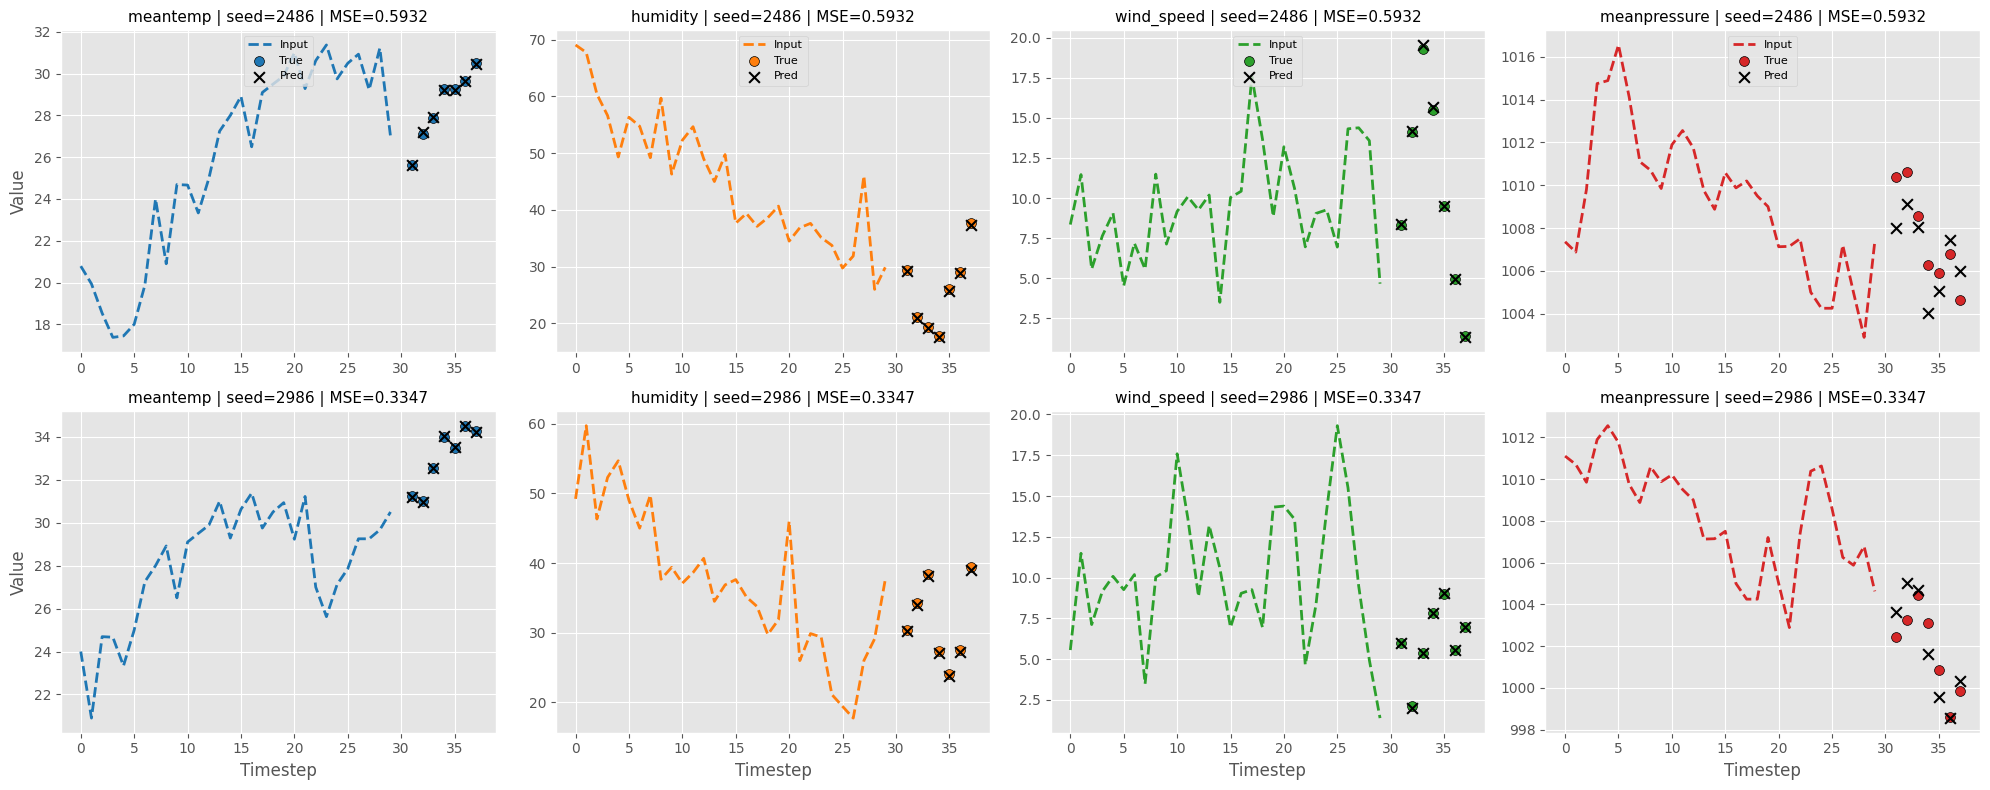

In [27]:
# Visualize
model_evaluation_and_visualizations(seq2seq_transformer, test_dataloader, device, stats=stats)
